#  MobileNet-v1   (TensorFlow 2 / Keras functional API)
- Reimplements the 2017 paper “MobileNets: Efficient Convolutional
- Depth-wise separable convolutions (DW->PW) are used everywhere except the very first 3x3 Conv stem.
- Two hyper-parameters expose the accuracy-vs-efficiency trade-off:
-  α - width multiplier (thins every layer)
- input_shape - indirectly the resolution multiplier ρ
- Each conv layer is followed by BatchNorm + ReLU6 (8-bit friendly).

In [2]:
!pip install tensorflow-datasets

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
# Helper ------------------------------------------------------

def _make_divisible(v: int, divisor: int = 8, min_value: int | None = None) -> int:
    """
    Ensure `v` is divisible by `divisor` (default 8, per MobileNet paper).
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # avoid rounding down by more than 10 %
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v




# ------------------------------------------------------------
#  CIFAR‑100 → 224×224 pipeline
# # ------------------------------------------------------------
def load_cifar100_resized(batch_size=128, img_size=224):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

    # Resize and normalize images
    x_train = tf.image.resize(x_train, [img_size, img_size]) / 255.0
    x_test = tf.image.resize(x_test, [img_size, img_size]) / 255.0

    # Convert to tf.data.Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    return train_ds, test_ds



In [5]:
# Core block --------------------------------------------------

def _depthwise_separable(x: tf.Tensor, point_channels: int, stride: int) -> tf.Tensor:
    """
    Depth-wise 3×3 conv  ➔  BN ➔ ReLU6 ➔
    Point-wise 1×1 conv ➔  BN ➔ ReLU6
    """
    # depth-wise
    x = layers.DepthwiseConv2D(
        3, strides=stride, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6.0)(x)

    # point-wise
    x = layers.Conv2D(
        point_channels, 1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6.0)(x)
    return x

def mobilnet_block (x, filters, strides):

    x = layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters = filters, kernel_size = 1, strides = 1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

In [6]:
# Public factory ---------------------------------------------

# def MobileNetV1(
#     *,
#     alpha: float = 1.0,
#     input_shape: tuple[int, int, int] = (224, 224, 3),
#     num_classes: int = 1000,
# ) -> tf.keras.Model:
#     """Build a MobileNet‑v1 Keras model.

#     Args:
#         alpha: width multiplier (1.0 = paper baseline; 0.75/0.5/0.25 thinner)
#         input_shape: (H, W, C) – C must be 3 for RGB images.
#         num_classes: output dimension for the softmax classifier.

#     Returns:
#         *tf.keras.Model* ready for compilation / training.
#     """
#     assert input_shape[2] == 3, "MobileNet v1 expects RGB inputs (C = 3)."

#     # Convenience lambda to scale channels by α and keep divisible by 8.
#     def c(channels: int) -> int:
#         return _make_divisible(int(channels * alpha))

#     inputs = layers.Input(shape=input_shape)

#     # Stem – full 3×3 convolution (the only non‑DW layer)
#     x = layers.Conv2D(c(32), 3, strides=2, padding="same", use_bias=False)(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU(max_value=6.0)(x)

#     # Configuration: (out_channels, stride)
#     cfg: list[tuple[int, int]] = [(64, 1),(128, 2), (128, 1),(256, 2),(256, 1),(512, 2)] + [(512, 1)] * 5 + [(1024, 2), (1024, 1)]

#     # 13 depth‑wise separable layers in total
#     for out_c, s in cfg:
#         x = _depthwise_separable(x, c(out_c), s)

#     # Head -----------------------------------------------------
#     x = layers.GlobalAveragePooling2D()(x)
#     outputs = layers.Dense(num_classes, activation="softmax")(x)

#     model = models.Model(inputs, outputs, name=f"MobileNetV1_{alpha}")
#     return model

def MobileNetV1(
    *,
    alpha: float = 1.0,
    input_shape: tuple[int, int, int] = (224, 224, 3),
    num_classes: int = 1000,
) -> tf.keras.Model:
    """
    MobileNet-v1 (Howard et al., 2017).

    Args
    ----
    alpha        : width multiplier (1.0 = baseline, 0.75 / 0.5 / 0.25 thinner)
    input_shape  : (H, W, 3) – expect RGB images.
    num_classes  : size of the softmax classifier head.

    Returns
    -------
    tf.keras.Model ready for compile / training / inference.
    """
    if input_shape[2] != 3:
        raise ValueError("MobileNet-v1 expects RGB inputs (channels = 3).")

    # Helper – scale channel count by α and keep divisible by 8
    def c(channels: int) -> int:
        return _make_divisible(int(channels * alpha))

    inputs = layers.Input(shape=input_shape)

    # ---- Stem (single full conv) ------------------------------------
    x = layers.Conv2D(c(32), 3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6.0)(x)

    # ---- 13 depth-wise separable blocks -----------------------------
    cfg: list[tuple[int, int]] = (
        # (pointwise_out_channels, stride)
        [(64, 1),
         (128, 2), (128, 1),
         (256, 2), (256, 1),
         (512, 2)] +
        [(512, 1)] * 5 +            # repeat 5× at 14×14
        [(1024, 2), (1024, 1)]
    )

    for out_c, stride in cfg:
        x = _depthwise_separable(x, c(out_c), stride)

    # ---- Head -------------------------------------------------------
    x = layers.GlobalAveragePooling2D()(x)            # (None, 1024)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name=f"MobileNetV1_{alpha:g}")


# Public factory ---------------------------------------------

def MobileNetV1_1(
    *,
    alpha: float = 1.0,
    input_shape: tuple[int, int, int] = (224, 224, 3),
    num_classes: int = 1000,
) -> tf.keras.Model:
    """Build a MobileNet‑v1 Keras model.

    Args:
        alpha: width multiplier (1.0 = paper baseline; 0.75/0.5/0.25 thinner)
        input_shape: (H, W, C) – C must be 3 for RGB images.
        num_classes: output dimension for the softmax classifier.

    Returns:
        *tf.keras.Model* ready for compilation / training.
    """
    input = layers.Input(shape = input_shape)
    x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = mobilnet_block(x, filters = 64, strides = 1)
    x = mobilnet_block(x, filters = 128, strides = 2)
    x = mobilnet_block(x, filters = 128, strides = 1)
    x = mobilnet_block(x, filters = 256, strides = 2)
    x = mobilnet_block(x, filters = 256, strides = 1)
    x = mobilnet_block(x, filters = 512, strides = 2)
    for _ in range (5):
        x = mobilnet_block(x, filters = 512, strides = 1)
    x = mobilnet_block(x, filters = 1024, strides = 2)
    x = mobilnet_block(x, filters = 1024, strides = 1)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense (units = num_classes, activation = 'softmax')(x)
    model = models.Model(inputs=input, outputs=output)
    model.summary()
    return model

In [7]:
model = MobileNetV1(alpha=1.0, input_shape=(32, 32, 3), num_classes=100)
model.summary()
# model = MobileNetV1_1(alpha=1.0, input_shape=(224, 224, 3), num_classes=100)

Model: "MobileNetV1_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 16, 16, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 8, 8, 64)       │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 8, 8, 128)      │         1,152 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,331,364 (12.71 MB)

 Trainable params: 3,309,476 (12.62 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [8]:
model = MobileNetV1(alpha=1.0, input_shape=(32, 32, 3), num_classes=100)
model.summary()  # ≈ 4.2 M params, matching the original paper

# Example compile statement (use your preferred optimiser / loss)
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Step 4: Add EarlyStopping + Checkpoint
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "mobilenet_cifar100_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False
)

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

# # history = model.fit(
# #     x_train, y_train,
# #     batch_size=64,
# #     epochs=50,
# #     validation_split=0.1,  # reserves 10% for validation
# #     callbacks=[early_stop, checkpoint]
# # )
# x_train.shape

Model: "MobileNetV1_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_13             │ (None, 16, 16, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_14             │ (None, 8, 8, 64)       │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_15             │ (None, 8, 8, 128)      │         1,152 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,331,364 (12.71 MB)

 Trainable params: 3,309,476 (12.62 MB)

 Non-trainable params: 21,888 (85.50 KB)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


(50000, 32, 32, 3)

In [24]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# ----- 1. augmentation (includes ONE rescale) -----
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1./255),           # normalise once
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
], name="data_aug")

# ----- 2. model -----
model = tf.keras.Sequential([
    data_augmentation,                           # runs only in training
    MobileNetV1(alpha=1.0,
                input_shape=(32, 32, 3),
                num_classes=100)
])

# ----- 3. data (batch/shuffle only) -----
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
              .shuffle(50_000)
              .batch(64)
              .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
              .batch(64)
              .prefetch(AUTOTUNE))

# ----- 4. compile & train -----
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_ds,                      # or: model.fit(x_train, y_train, ...)
    epochs=100,
    validation_data=val_ds,        # or: validation_data=(x_test, y_test)
    callbacks=[early_stop, checkpoint]
)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.2005 - loss: 2.3053 - val_accuracy: 0.3333 - val_loss: 1.7869
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.3496 - loss: 1.7842 - val_accuracy: 0.3458 - val_loss: 2.0521
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.3966 - loss: 1.6681 - val_accuracy: 0.3695 - val_loss: 1.9201
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4219 - loss: 1.5852 - val_accuracy: 0.4303 - val_loss: 1.5928
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4599 - loss: 1.5030 - val_accuracy: 0.3813 - val_loss: 2.1176
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.4641 - loss: 1.5011 - val_accuracy: 0.4978 - val_loss: 1.4827
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.4964 - loss: 1.3930 - val_accuracy: 0.5287 - val_loss: 1.3727
Epoch 8/100
782/782 ━━━━━━━━━━

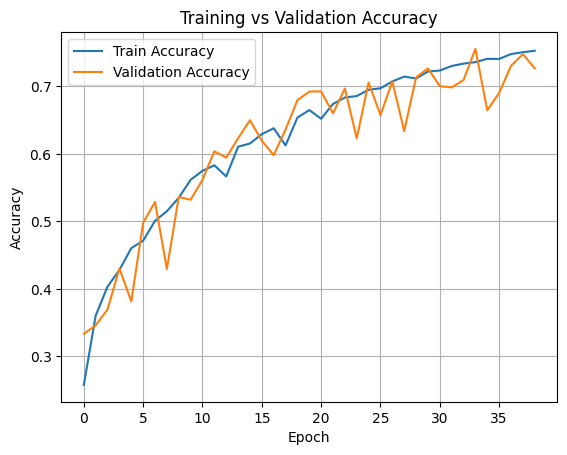

In [25]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()

In [35]:
y_test.shape

(10000, 1)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1️⃣  ground-truth labels
y_true = y_test.squeeze()          # shape (N,)

# 2️⃣  model predictions → class IDs
y_pred = np.argmax(model.predict(x_test, batch_size=64, verbose=1), axis=1)

# 3️⃣  metrics
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
print("Confusion-matrix shape:", cm)   # (10,10) for CIFAR-10, (100,100) for CIFAR-100


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0      0.816     0.750     0.782      1000
           1      0.813     0.890     0.850      1000
           2      0.752     0.647     0.696      1000
           3      0.781     0.402     0.531      1000
           4      0.753     0.704     0.728      1000
           5      0.719     0.664     0.691      1000
           6      0.680     0.900     0.775      1000
           7      0.727     0.869     0.791      1000
           8      0.854     0.852     0.853      1000
           9      0.709     0.876     0.784      1000

    accuracy                          0.755     10000
   macro avg      0.760     0.755     0.748     10000
weighted avg      0.760     0.755     0.748     10000

Confusion-matrix shape: [[750  36  35   4  24   0   7  19  55  70]
 [  3 890   0   0   0   1   8   2  14  82]
 [ 65   7 647  11  74  23  94  42  14  23]
 [ 12  20  67 402  49 166 124  61  23  76]
 [ 1

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Random left-right flip
    layers.RandomRotation(0.1),                # Small rotation
    layers.RandomZoom(0.1),                    # Slight zoom in/out
    layers.RandomTranslation(0.1, 0.1),        # Shift image
    layers.RandomContrast(0.1),                # Adjust brightness
])


def preprocess_dog_image(image, label, size, augment=False):
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32) / 255.0
    if augment:
        image = data_augmentation(image)
    return image, label


def load_stanford_dogs(batch_size=64):
    train_raw = tfds.load('stanford_dogs', split='train[:90%]', as_supervised=True)
    val_raw = tfds.load('stanford_dogs', split='train[90%:]', as_supervised=True)

    train_ds = train_raw.map(lambda x, y: preprocess_dog_image(x, y, size=[224, 224], augment=True),
                             num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_raw.map(lambda x, y: preprocess_dog_image(x, y, size=[224, 224], augment=False),
                         num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds


In [ ]:
model = MobileNetV1(alpha=1, num_classes=120)
model.summary()  # ≈ 4.2 M params, matching the original paper

# Example compile statement (use your preferred optimiser / loss)
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Step 4: Add EarlyStopping + Checkpoint
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "mobilenet_stanford_dogs.keras",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False
)

batch_size = 64
train_ds, val_ds = load_stanford_dogs(batch_size=batch_size)

history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint]
)


Model: "MobileNetV1_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_13             │ (None, 112, 112, 32)   │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_14             │ (None, 56, 56, 64)     │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_15             │ (None, 56, 56, 128)    │         1,152 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,351,864 (12.79 MB)

 Trainable params: 3,329,976 (12.70 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.0123 - loss: 4.9440 - val_accuracy: 0.0100 - val_loss: 5.1467
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 226s 970ms/step - accuracy: 0.0301 - loss: 4.5956 - val_accuracy: 0.0100 - val_loss: 5.3858
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 178s 974ms/step - accuracy: 0.0430 - loss: 4.3660 - val_accuracy: 0.0083 - val_loss: 5.4854
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 203s 979ms/step - accuracy: 0.0581 - loss: 4.2000 - val_accuracy: 0.0250 - val_loss: 5.1725
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 201s 973ms/step - accuracy: 0.0799 - loss: 4.0237 - val_accuracy: 0.0392 - val_loss: 4.5699
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 968ms/step - accuracy: 0.1040 - loss: 3.8526 - val_accuracy: 0.0383 - val_loss: 5.3816
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 202s 969ms/step - accuracy: 0.1166 - loss: 3.7122 - val_accuracy: 0.0433 - val_loss: 4.8337
Epoch 8/50
116/169 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1398 - loss: 

KeyboardInterrupt: 

In [ ]:
def load_cifar100_32x32(batch_size=128):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    def preprocess(x, y, train=True):
        x = tf.cast(x, tf.float32) / 255.0
        if train:
            x = data_augmentation(x)
        return x, tf.squeeze(y)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(
        lambda x, y: preprocess(x, y, train=True),
        num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(
        lambda x, y: preprocess(x, y, train=False),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "mobilenetv1_cifar100_adam.keras",
    monitor='val_accuracy',
    save_best_only=True
)

# Load data and train
train_ds, val_ds = load_cifar100_32x32(batch_size=128)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 129ms/step - accuracy: 0.0418 - loss: 4.4640 - val_accuracy: 0.0123 - val_loss: 5.2965
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.1026 - loss: 3.9147 - val_accuracy: 0.0678 - val_loss: 4.3566
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.1289 - loss: 3.6962 - val_accuracy: 0.1363 - val_loss: 3.7044
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.1491 - loss: 3.5871 - val_accuracy: 0.1595 - val_loss: 3.5551
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.1672 - loss: 3.5004 - val_accuracy: 0.1734 - val_loss: 3.4240
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.1741 - loss: 3.4055 - val_accuracy: 0.1295 - val_loss: 4.6450
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.1868 - loss: 3.3593 - val_accuracy: 0.1915 - val_loss: 3.3667
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.2011 - loss: 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def preprocess_rps(image, label, img_size=(224, 224)):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_rps_dataset(batch_size=32, img_size=(224, 224)):
    train_raw = tfds.load("rock_paper_scissors", split="train[:80%]", as_supervised=True)
    val_raw = tfds.load("rock_paper_scissors", split="train[80%:]", as_supervised=True)

    train_ds = train_raw.map(lambda x, y: preprocess_rps(x, y, img_size),
                             num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_raw.map(lambda x, y: preprocess_rps(x, y, img_size),
                         num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = train_ds.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds


In [ ]:
model = MobileNetV1(alpha=1.0, input_shape=(224, 224, 3), num_classes=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "mobilenet_rps_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False
)

train_ds, val_ds = load_rps_dataset(batch_size=32)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.CASDIM_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.CASDIM_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.7335 - loss: 0.5992 - val_accuracy: 0.3472 - val_loss: 1.4659
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9792 - loss: 0.0620 - val_accuracy: 0.3472 - val_loss: 1.9894
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9986 - loss: 0.0068 - val_accuracy: 0.3472 - val_loss: 2.4463
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9903 - loss: 0.0286 - val_accuracy: 0.3472 - val_loss: 2.5160
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9910 - loss: 0.0257 - val_accuracy: 0.3472 - val_loss: 2.3380
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9982 - loss: 0.0039 - val_accuracy: 0.3472 - val_loss: 2.4674


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNetV1 (No Augmentation) on Rock-Paper-Scissors")
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load 160px version
train_raw = tfds.load('imagenette', split='train', as_supervised=True)
val_raw = tfds.load('imagenette', split='validation', as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/incomplete.PQ2C55_1.0.0/imagenette-train.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/incomplete.PQ2C55_1.0.0/imagenette-validation.tfre…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 128

def preprocess(img, label):
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = train_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = val_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Image batch shape: (128, 224, 224, 3)
Label batch shape: (128,)


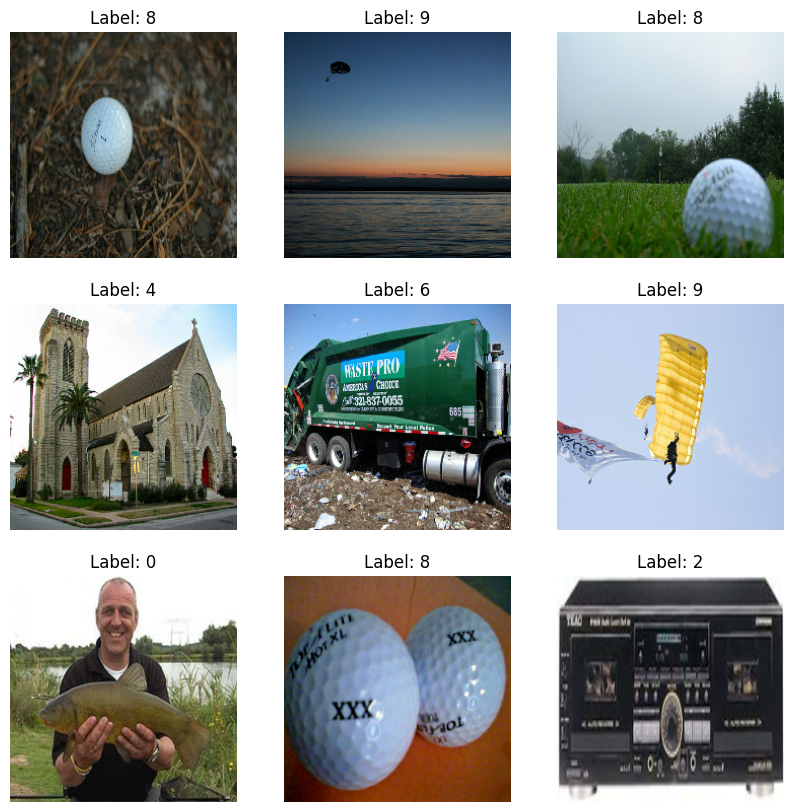

In [ ]:
import matplotlib.pyplot as plt

# Fetch one batch from the training dataset
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)  # Should be (BATCH_SIZE, 160, 160, 3)
    print("Label batch shape:", labels.shape)

    # Plot the first 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break


In [ ]:
model = MobileNetV1_1(alpha=1.0, input_shape=(224, 224, 3), num_classes=10)

# model.summary()

# Step 4: Add EarlyStopping + Checkpoint
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "mobilenet_imagenette_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    epochs=90,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_243         │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_243 (ReLU)                │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_117            │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_244         │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_244 (ReLU)                │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_245         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_245 (ReLU)                │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_118            │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_246         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_246 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_247         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_247 (ReLU)                │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_119            │ (None, 56, 56, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_248         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_248 (ReLU)                │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,258,808 (16.25 MB)

 Trainable params: 4,236,920 (16.16 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/90


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None,), output.shape=(None, 7, 1, 1000)